In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.roberta_conf
encoding_type = 'relative'
model_name = 'roberta'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100
task_name='about'
global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6052279081390295 	 Validation loss: 0.42233921309648936 	 
  1%|          | 574/57400 [01:41<2:26:42,  6.46it/s]
Epoch 2 	 Training loss: 0.41342243650856747 	 Validation loss: 0.3636142055867082 	 
  2%|▏         | 1148/57400 [03:21<2:28:55,  6.30it/s]
Epoch 3 	 Training loss: 0.3710335944276238 	 Validation loss: 0.34025233074770134 	 
  3%|▎         | 1722/57400 [05:01<2:32:04,  6.10it/s]
Epoch 4 	 Training loss: 0.3518564702378333 	 Validation loss: 0.33053995441582246 	 
  4%|▍         | 2296/57400 [06:42<2:34:26,  5.95it/s]
Epoch 5 	 Training loss: 0.33706466612188657 	 Validation loss: 0.3205562443551371 	 
  5%|▌         | 2870/57400 [08:24<2:33:24,  5.92it/s]
Epoch 6 	 Training loss: 0.32626954673786196 	 Validation loss: 0.3159082387968645 	 
  6%|▌         | 3444/57400 [10:05<2:26:28,  6.14it/s]
Epoch 7 	 Training loss: 0.3171823150916382 	 Validation loss: 0.31173760709116016 	 
  7%|▋         | 4018/57400 [11:46<2:24:17,  6.17it/s]
Epoch 8 	 Trai

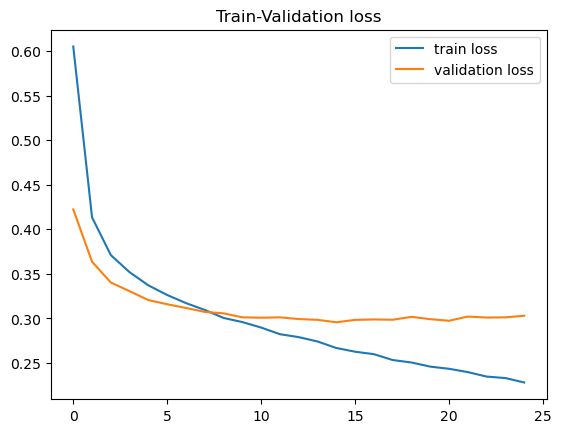

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p, c, epochs = train.train_function(model,num_epochs,dl_train[task_name],optimizer,early_stop=10,dl_val=dl_val[task_name],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

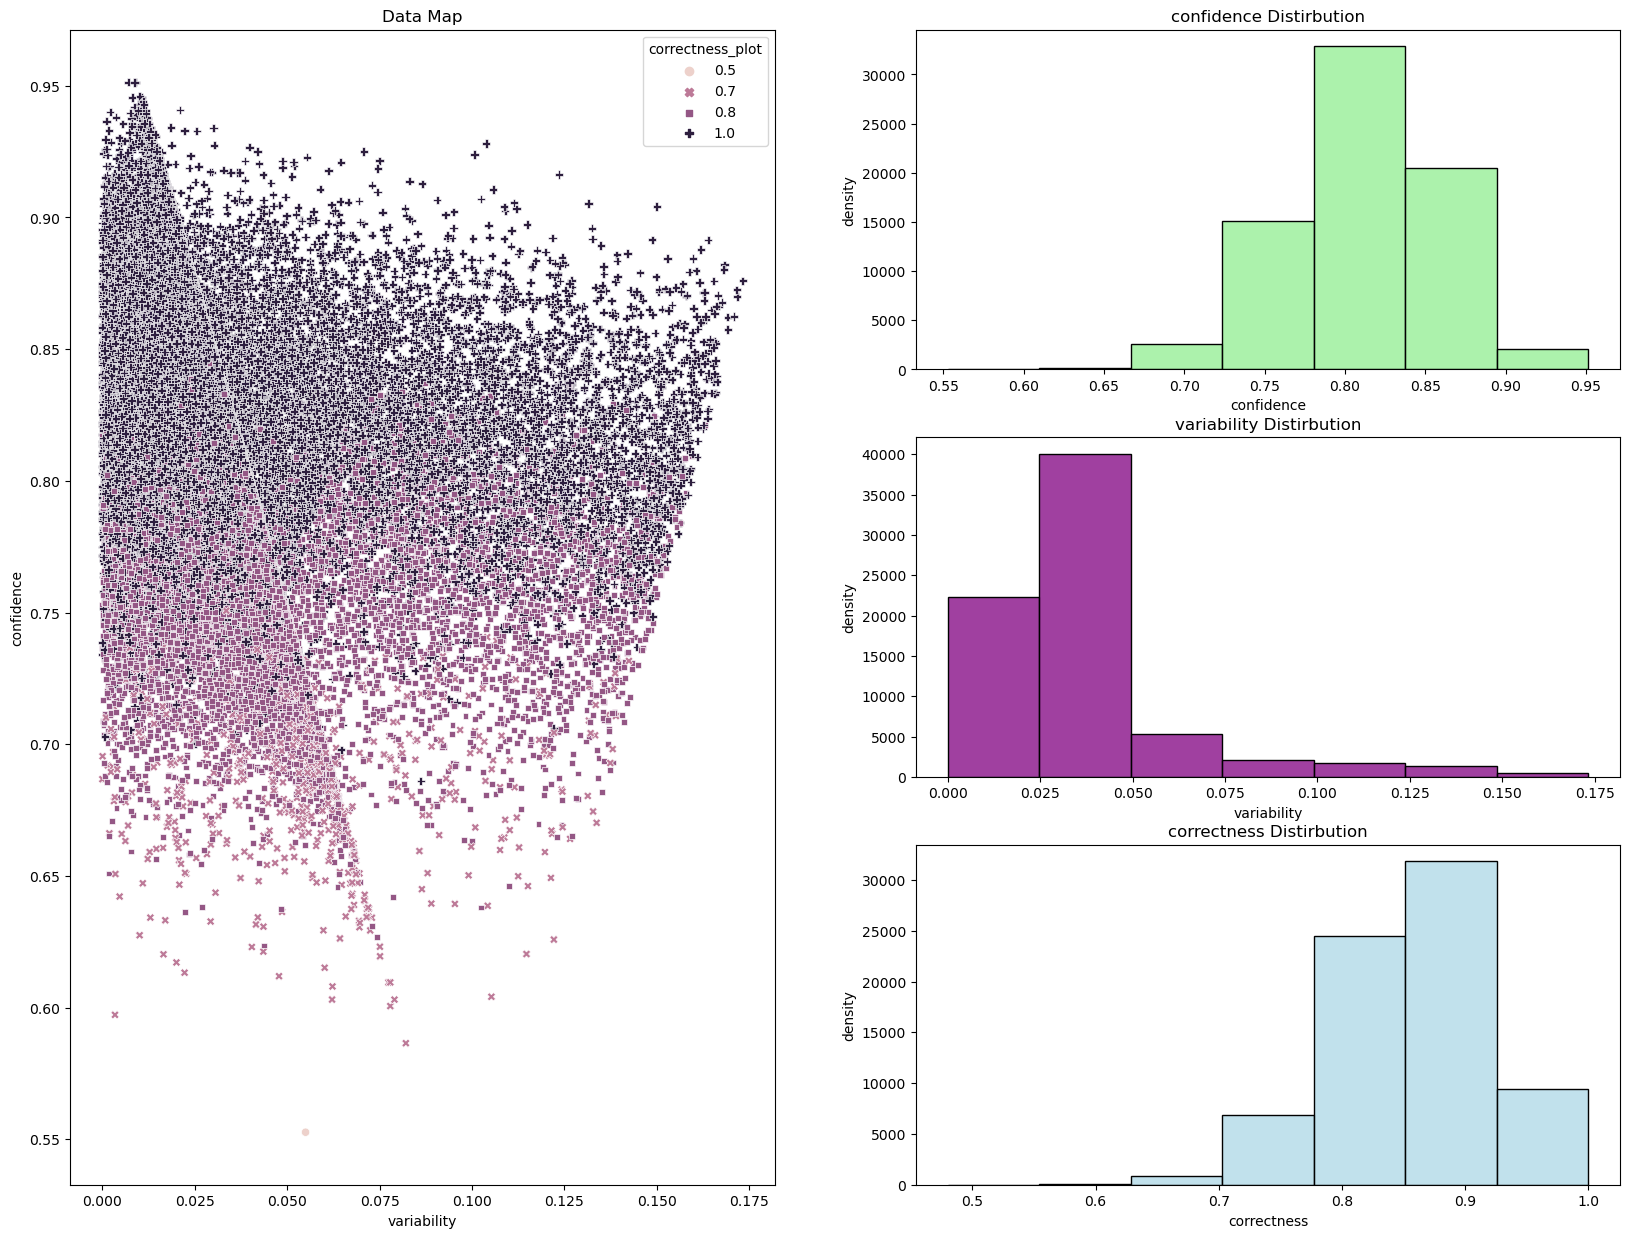

In [18]:
train.get_datamap_complete_graph(p,correctness_vector=c,num_epochs=epochs)

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8525, 'male': 0.8776041666666666, 'average': 0.8650520833333333}
precision {'female': 0.8788659793814433, 'male': 0.851010101010101, 'average': 0.8649380401957721}
f1 {'female': 0.8654822335025381, 'male': 0.864102564102564, 'average': 0.864792398802551}
accuracy 0.8647959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.6797900262467191, 'male': 0.7299270072992701, 'average': 0.7048585167729946}
precision {'female': 0.7, 'male': 0.7109004739336493, 'average': 0.7054502369668246}
f1 {'female': 0.6897470039946738, 'male': 0.7202881152460985, 'average': 0.7050175596203861}
accuracy 0.7058080808080808


Evaluación en el conjunto el conjunto as
recall {'female': 0.6630727762803235, 'male': 0.7272727272727273, 'average': 0.6951727517765254}
precision {'female': 0.6949152542372882, 'male': 0.6973365617433414, 'average': 0.6961259079903148}
f1 {'female': 0.6786206896551724, 'male': 0.7119901112484549, 'av

In [20]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5611197431847609 	 Validation loss: 0.3975034123760159 	 
  1%|          | 574/57400 [01:38<2:28:37,  6.37it/s]
Epoch 2 	 Training loss: 0.3986079207903832 	 Validation loss: 0.35409325234970807 	 
  2%|▏         | 1148/57400 [03:18<5:50:15,  2.68it/s]
Epoch 3 	 Training loss: 0.36563838499140655 	 Validation loss: 0.33544321686534556 	 
  3%|▎         | 1722/57400 [04:57<2:31:30,  6.13it/s]
Epoch 4 	 Training loss: 0.34760117650239725 	 Validation loss: 0.3230713891275859 	 
  4%|▍         | 2296/57400 [06:37<4:47:54,  3.19it/s]
Epoch 5 	 Training loss: 0.33342932676085196 	 Validation loss: 0.31485181844840615 	 
  5%|▌         | 2870/57400 [08:15<2:21:49,  6.41it/s]
Epoch 6 	 Training loss: 0.3230436764371935 	 Validation loss: 0.3153148851657318 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:53<2:20:09,  6.42it/s]
Epoch 7 	 Training loss: 0.3136039781757348 	 Validation loss: 0.3070647322525412 	 
  7%|▋         | 4018/57400 [11:33<2:34:0

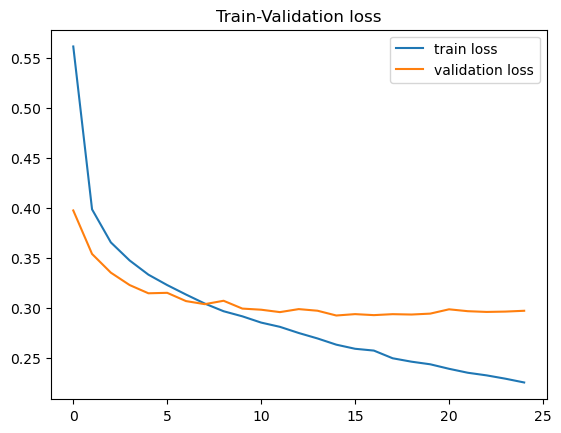

In [21]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p, c, epochs = train.train_function(model,num_epochs,dl_train[task_name],optimizer,early_stop=10,dl_val=dl_val[task_name],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

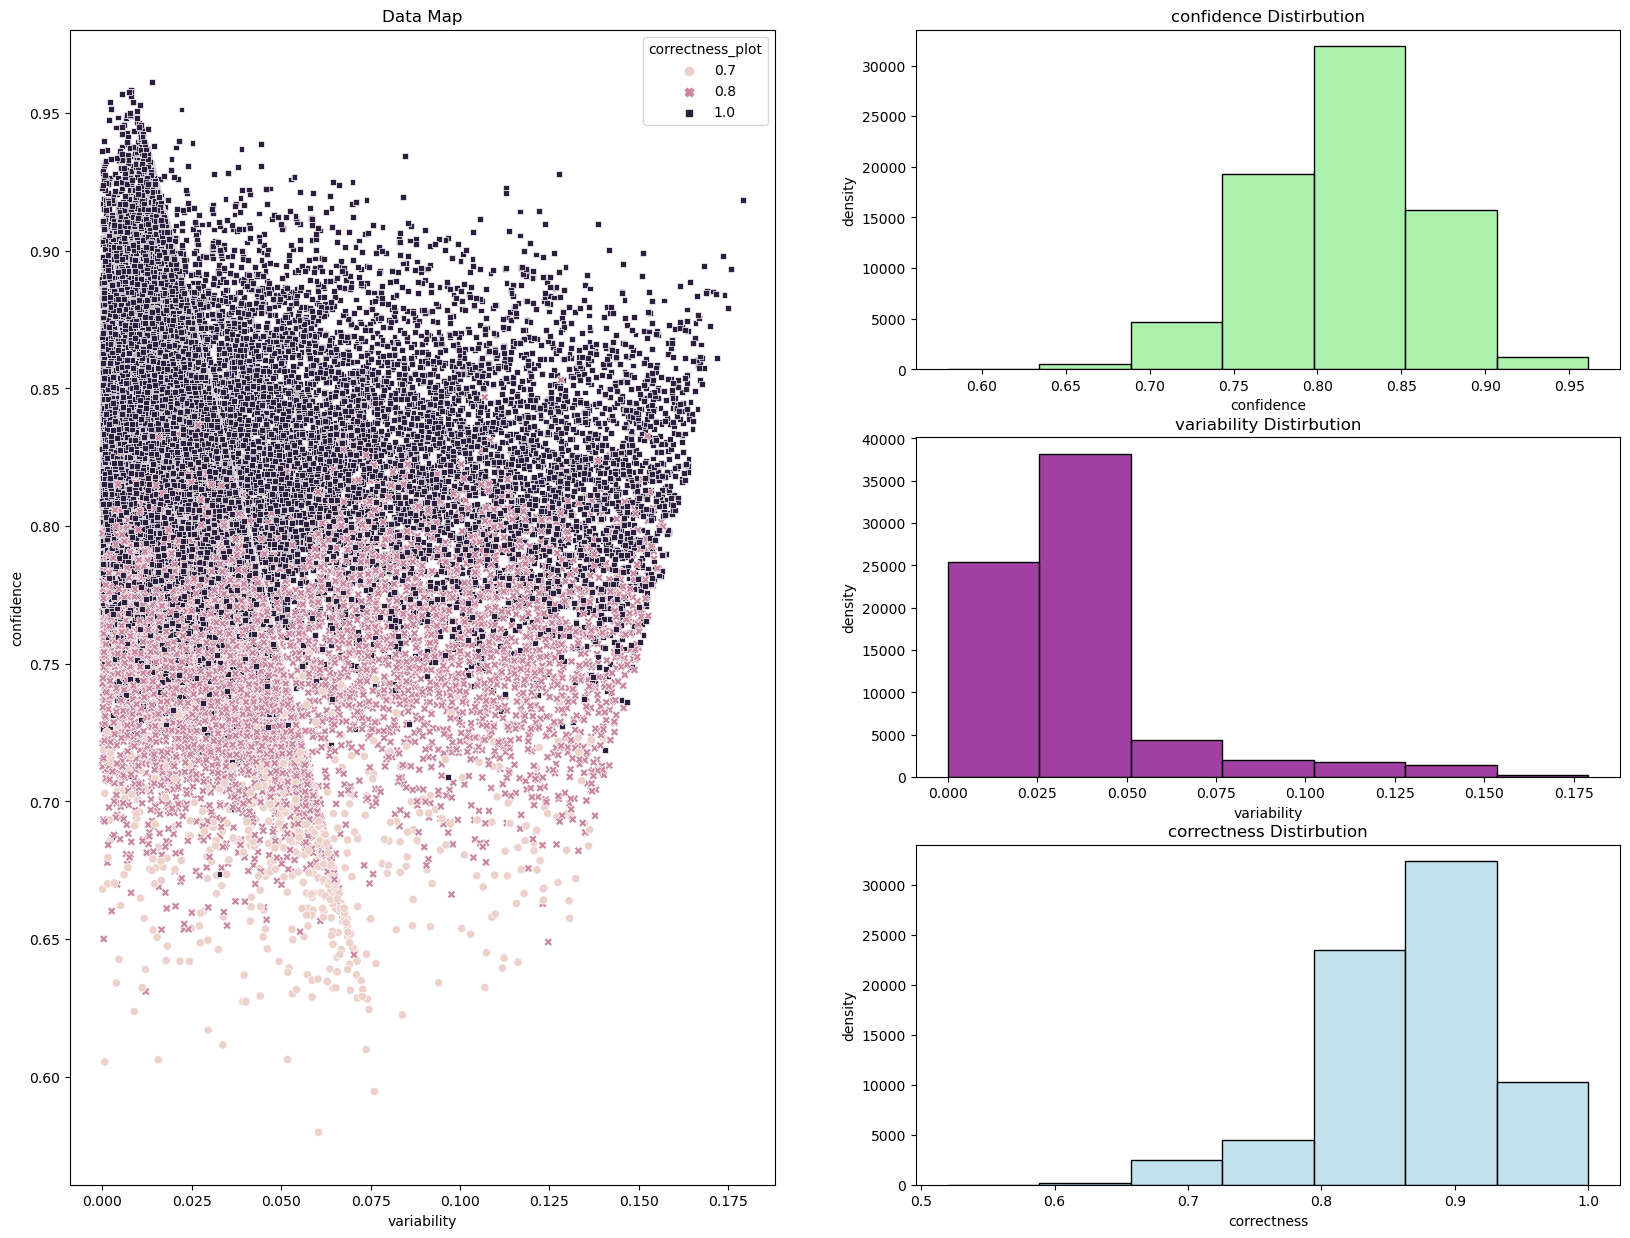

In [22]:
train.get_datamap_complete_graph(p,correctness_vector=c,num_epochs=epochs)

In [23]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.85, 'male': 0.8567708333333334, 'average': 0.8533854166666667}
precision {'female': 0.8607594936708861, 'male': 0.8457583547557841, 'average': 0.853258924213335}
f1 {'female': 0.8553459119496856, 'male': 0.8512289780077621, 'average': 0.8532874449787238}
accuracy 0.8533163265306123


Evaluación en el conjunto el conjunto to
recall {'female': 0.6902887139107612, 'male': 0.732360097323601, 'average': 0.711324405617181}
precision {'female': 0.7050938337801609, 'male': 0.7183770883054893, 'average': 0.711735461042825}
f1 {'female': 0.6976127320954908, 'male': 0.7253012048192771, 'average': 0.7114569684573839}
accuracy 0.7121212121212122


Evaluación en el conjunto el conjunto as
recall {'female': 0.660377358490566, 'male': 0.7146464646464646, 'average': 0.6875119115685153}
precision {'female': 0.6843575418994413, 'male': 0.6919315403422983, 'average': 0.6881445411208698}
f1 {'female': 0.6721536351165981, 'male': 0.7031055900

In [24]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5905907768821052 	 Validation loss: 0.40456103167291413 	 
  1%|          | 574/57400 [01:39<2:37:05,  6.03it/s]
Epoch 2 	 Training loss: 0.4068883640321705 	 Validation loss: 0.35654843106108197 	 
  2%|▏         | 1148/57400 [03:19<2:17:35,  6.81it/s]
Epoch 3 	 Training loss: 0.3713971438983176 	 Validation loss: 0.3381421078564757 	 
  3%|▎         | 1722/57400 [04:58<2:27:13,  6.30it/s]
Epoch 4 	 Training loss: 0.35241925031050575 	 Validation loss: 0.32933597797054354 	 
  4%|▍         | 2296/57400 [06:38<2:31:52,  6.05it/s]
Epoch 5 	 Training loss: 0.33631989248226746 	 Validation loss: 0.3209162293854406 	 
  5%|▌         | 2870/57400 [08:17<2:13:26,  6.81it/s]
Epoch 6 	 Training loss: 0.3262734576696303 	 Validation loss: 0.3242119040529607 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:57<2:28:30,  6.06it/s]
Epoch 7 	 Training loss: 0.3169372159118021 	 Validation loss: 0.31276278020971915 	 
  7%|▋         | 4018/57400 [11:37<2:06:5

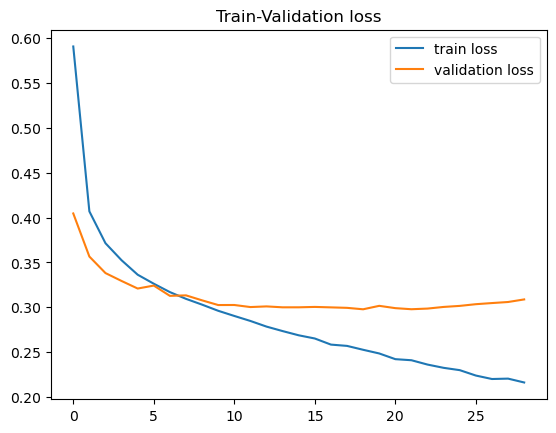

In [25]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p, c, epochs = train.train_function(model,num_epochs,dl_train[task_name],optimizer,early_stop=10,dl_val=dl_val[task_name],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'_probs'+'.pt')
torch.save(c,save_path+'_corr'+'.pt')

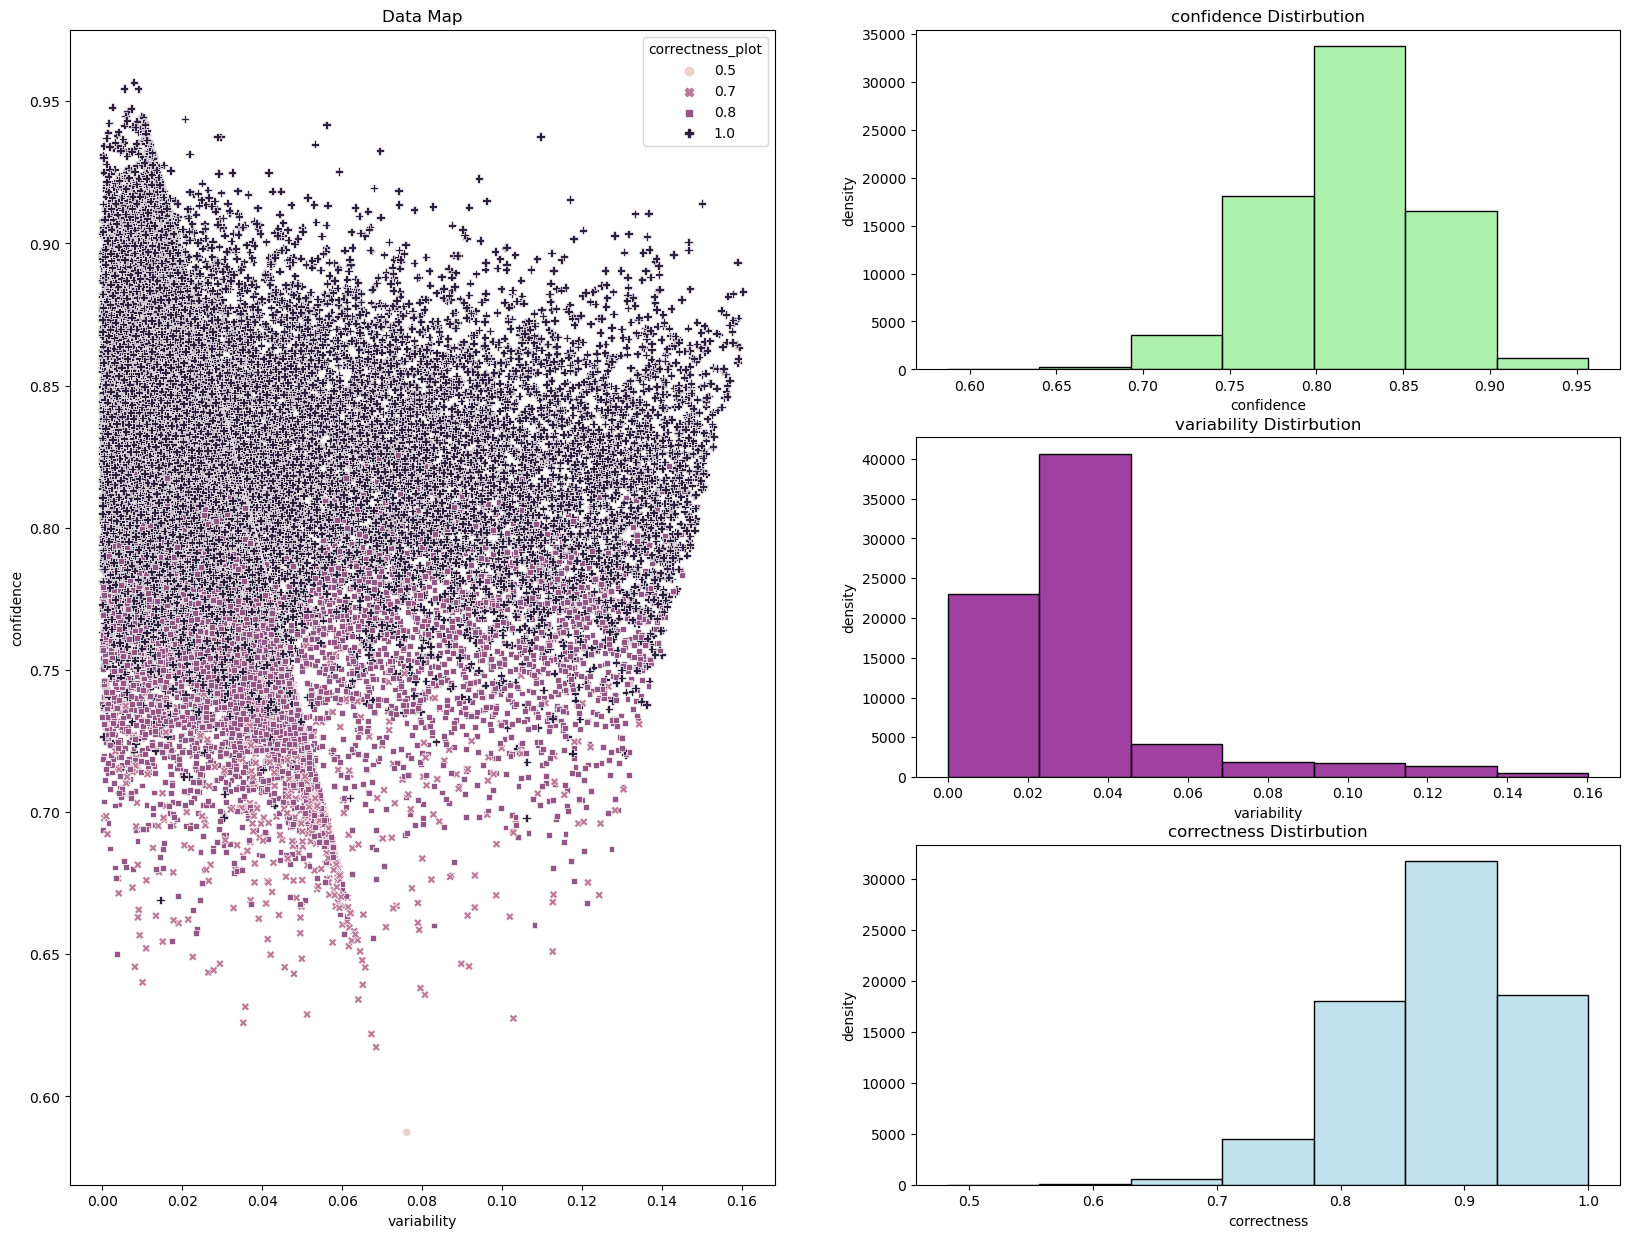

In [26]:
train.get_datamap_complete_graph(p,correctness_vector=c,num_epochs=epochs)

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.85, 'male': 0.8671875, 'average': 0.85859375}
precision {'female': 0.8695652173913043, 'male': 0.8473282442748091, 'average': 0.8584467308330568}
f1 {'female': 0.8596713021491782, 'male': 0.8571428571428571, 'average': 0.8584070796460177}
accuracy 0.8584183673469388


Evaluación en el conjunto el conjunto to
recall {'female': 0.6876640419947506, 'male': 0.7153284671532847, 'average': 0.7014962545740177}
precision {'female': 0.6912928759894459, 'male': 0.711864406779661, 'average': 0.7015786413845535}
f1 {'female': 0.6894736842105262, 'male': 0.7135922330097086, 'average': 0.7015329586101174}
accuracy 0.702020202020202


Evaluación en el conjunto el conjunto as
recall {'female': 0.6846361185983828, 'male': 0.7070707070707071, 'average': 0.6958534128345449}
precision {'female': 0.6864864864864865, 'male': 0.7052896725440806, 'average': 0.6958880795152835}
f1 {'female': 0.6855600539811066, 'male': 0.7061790668348046, 'avera

Resultados finales

In [28]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8588289744757641
f1 etiqueta male: 0.8574914664177278
f1 etiqueta female:  0.8601664825338006


TO
Resultado global f1: 0.7060024955626292
f1 etiqueta male: 0.7197271843583614
f1 etiqueta female:  0.692277806766897


AS
Resultado global f1: 0.6929348578163748
f1 etiqueta male: 0.7070915893817904
f1 etiqueta female:  0.678778126250959


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8590104166666667
recall etiqueta male: 0.8671875
recall etiqueta female:  0.8508333333333333


TO
Resultado global recall: 0.7058930589880644
recall etiqueta male: 0.7258718572587186
recall etiqueta female:  0.6859142607174104


AS
Resultado global recall: 0.6928460253931952
recall etiqueta male: 0.7163299663299664
recall etiqueta female:  0.6693620844564241


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.858881231747388
precision etiqueta male: 0.848032233346898
precision etiqueta female:  0.86973023014787

# TO

In [26]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6970669224287159 	 Validation loss: 0.6935916684441648 	 
  1%|          | 574/57400 [01:47<2:29:21,  6.34it/s]
Epoch 2 	 Training loss: 0.6951191986064047 	 Validation loss: 0.6943882612858788 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:34<2:32:45,  6.14it/s]
Epoch 3 	 Training loss: 0.6951939336929587 	 Validation loss: 0.6928940566919618 	 
  3%|▎         | 1722/57400 [05:22<2:27:19,  6.30it/s]
Epoch 4 	 Training loss: 0.6951021480435694 	 Validation loss: 0.6930999836679232 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:09<2:19:56,  6.56it/s]
Epoch 5 	 Training loss: 0.6950233961854663 	 Validation loss: 0.6920150861901752 	 
  5%|▌         | 2870/57400 [08:57<2:17:49,  6.59it/s]
Epoch 6 	 Training loss: 0.695001940590164 	 Validation loss: 0.6928666840165348 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:45<2:22:09,  6.33it/s]
Epoch 7 	 Training loss: 0.6948660750214647 	 Validation loss: 0.6921328043

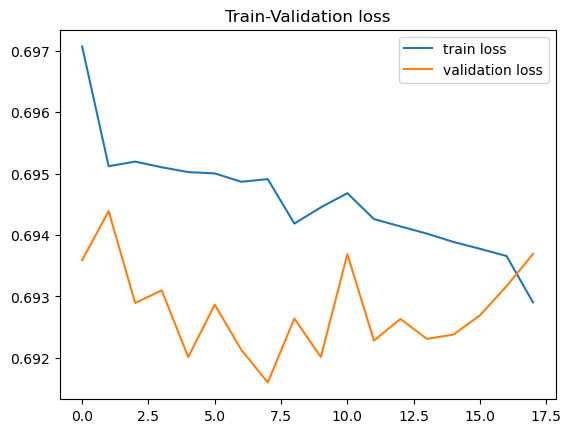

In [28]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8975, 'male': 0.20052083333333334, 'average': 0.5490104166666666}
precision {'female': 0.539039039039039, 'male': 0.652542372881356, 'average': 0.5957907059601975}
f1 {'female': 0.6735459662288931, 'male': 0.30677290836653387, 'average': 0.4901594372977135}
accuracy 0.5561224489795918


Evaluación en el conjunto el conjunto to
recall {'female': 0.8556430446194225, 'male': 0.24330900243309003, 'average': 0.5494760235262562}
precision {'female': 0.5117739403453689, 'male': 0.6451612903225806, 'average': 0.5784676153339747}
f1 {'female': 0.6404715127701375, 'male': 0.3533568904593639, 'average': 0.4969142016147507}
accuracy 0.5378787878787878


Evaluación en el conjunto el conjunto as
recall {'female': 0.8328840970350404, 'male': 0.22727272727272727, 'average': 0.5300784121538838}
precision {'female': 0.5024390243902439, 'male': 0.5921052631578947, 'average': 0.5472721437740693}
f1 {'female': 0.6267748478701826, 'male': 0.3

In [30]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6978905046235394 	 Validation loss: 0.6930948899964154 	 
  1%|          | 574/57400 [01:47<2:29:30,  6.33it/s]
Epoch 2 	 Training loss: 0.6961662032047631 	 Validation loss: 0.6930415084806539 	 
  2%|▏         | 1148/57400 [03:34<2:24:26,  6.49it/s]
Epoch 3 	 Training loss: 0.6963642546939518 	 Validation loss: 0.692473641896652 	 
  3%|▎         | 1722/57400 [05:21<2:29:11,  6.22it/s]
Epoch 4 	 Training loss: 0.6960944203134197 	 Validation loss: 0.6940944417048309 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:08<2:45:02,  5.56it/s]
Epoch 5 	 Training loss: 0.6960272420366467 	 Validation loss: 0.6936209858474085 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:55<2:16:54,  6.64it/s]
Epoch 6 	 Training loss: 0.6954828627433511 	 Validation loss: 0.6933600286305961 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:41<2:40:30,  5.60it/s]
Epoch 7 	 Training loss: 0.695904781386412 	 Validation loss: 0.69350480427

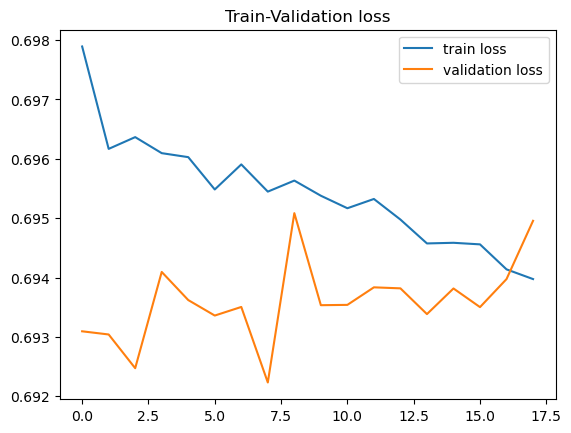

In [31]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [32]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9075, 'male': 0.109375, 'average': 0.5084375}
precision {'female': 0.5148936170212766, 'male': 0.5316455696202531, 'average': 0.5232695933207648}
f1 {'female': 0.6570135746606335, 'male': 0.1814254859611231, 'average': 0.4192195303108783}
accuracy 0.5165816326530612


Evaluación en el conjunto el conjunto to
recall {'female': 0.910761154855643, 'male': 0.17518248175182483, 'average': 0.542971818303734}
precision {'female': 0.5058309037900874, 'male': 0.6792452830188679, 'average': 0.5925380934044777}
f1 {'female': 0.6504217432052483, 'male': 0.27852998065764023, 'average': 0.46447586193144424}
accuracy 0.5290404040404041


Evaluación en el conjunto el conjunto as
recall {'female': 0.9245283018867925, 'male': 0.1590909090909091, 'average': 0.5418096054888508}
precision {'female': 0.507396449704142, 'male': 0.6923076923076923, 'average': 0.5998520710059172}
f1 {'female': 0.6552053486150907, 'male': 0.2587268993839836, 'ave

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6957264410701778 	 Validation loss: 0.6945673207105216 	 
  1%|          | 574/57400 [01:47<2:30:24,  6.30it/s]
Epoch 2 	 Training loss: 0.6955318852791803 	 Validation loss: 0.6937365956225637 	 
  2%|▏         | 1148/57400 [03:34<2:27:40,  6.35it/s]
Epoch 3 	 Training loss: 0.6949713652765294 	 Validation loss: 0.693248716451354 	 
  3%|▎         | 1722/57400 [05:21<2:44:30,  5.64it/s]
Epoch 4 	 Training loss: 0.6950361080701343 	 Validation loss: 0.6944105463512873 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:08<2:44:43,  5.58it/s]
Epoch 5 	 Training loss: 0.6947649531455821 	 Validation loss: 0.6933078614331908 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [08:54<2:22:17,  6.39it/s]
Epoch 6 	 Training loss: 0.6947834331814836 	 Validation loss: 0.6932735736087218 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:41<2:21:18,  6.36it/s]
Epoch 7 	 Training loss: 0.6943457195152389 	 Validation loss: 0.6942236746

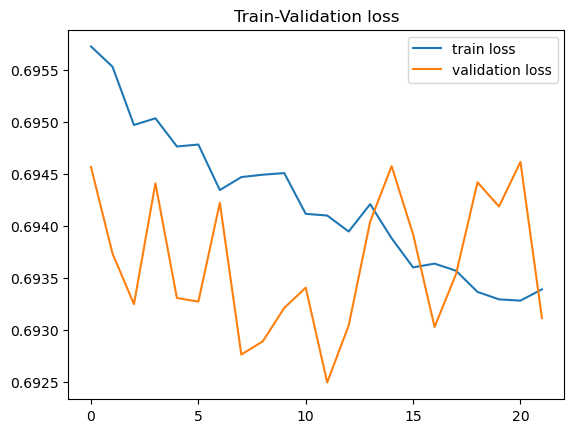

In [34]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [35]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.9225, 'male': 0.11458333333333333, 'average': 0.5185416666666667}
precision {'female': 0.5204513399153737, 'male': 0.5866666666666667, 'average': 0.5535590032910203}
f1 {'female': 0.6654643823264202, 'male': 0.19172113289760348, 'average': 0.4285927576120119}
accuracy 0.5267857142857143


Evaluación en el conjunto el conjunto to
recall {'female': 0.9002624671916011, 'male': 0.1435523114355231, 'average': 0.5219073893135621}
precision {'female': 0.4935251798561151, 'male': 0.6082474226804123, 'average': 0.5508863012682637}
f1 {'female': 0.637546468401487, 'male': 0.2322834645669291, 'average': 0.434914966484208}
accuracy 0.5075757575757576


Evaluación en el conjunto el conjunto as
recall {'female': 0.9487870619946092, 'male': 0.13131313131313133, 'average': 0.5400500966538703}
precision {'female': 0.5057471264367817, 'male': 0.7323943661971831, 'average': 0.6190707463169824}
f1 {'female': 0.6597938144329898, 'male': 0.22

Resultados finales

In [36]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.44599057507353457
f1 etiqueta male: 0.22663984240842014
f1 etiqueta female:  0.665341307738649


TO
Resultado global f1: 0.4654350100101343
f1 etiqueta male: 0.28805677856131107
f1 etiqueta female:  0.6428132414589576


AS
Resultado global f1: 0.4586110227320096
f1 etiqueta male: 0.2699640418245981
f1 etiqueta female:  0.647258003639421


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5253298611111111
recall etiqueta male: 0.14149305555555555
recall etiqueta female:  0.9091666666666667


TO
Resultado global recall: 0.5381184103811841
recall etiqueta male: 0.1873479318734793
recall etiqueta female:  0.8888888888888888


AS
Resultado global recall: 0.5373127047655349
recall etiqueta male: 0.17255892255892255
recall etiqueta female:  0.9020664869721473


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5575397675239941
precision etiqueta male: 0.5902848697227586
precision etiqueta female:  

# AS

In [37]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6941980279281165 	 Validation loss: 0.6932474132311546 	 
  1%|          | 574/57400 [01:46<2:31:15,  6.26it/s]
Epoch 2 	 Training loss: 0.693598888165444 	 Validation loss: 0.6930846915406695 	 
  2%|▏         | 1148/57400 [03:34<2:42:36,  5.77it/s]
Epoch 3 	 Training loss: 0.6929518698815269 	 Validation loss: 0.6931234537544897 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:20<2:21:25,  6.56it/s]
Epoch 4 	 Training loss: 0.6908352876581797 	 Validation loss: 0.6907278612508612 	 
  4%|▍         | 2296/57400 [07:08<2:42:54,  5.64it/s]
Epoch 5 	 Training loss: 0.6882926215278147 	 Validation loss: 0.6963657231654151 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [08:55<2:21:53,  6.41it/s]
Epoch 6 	 Training loss: 0.6877611315831905 	 Validation loss: 0.690930607965437 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:41<2:38:45,  5.66it/s]
Epoch 7 	 Training loss: 0.6863294322731603 	 Validation loss: 0.68981126809

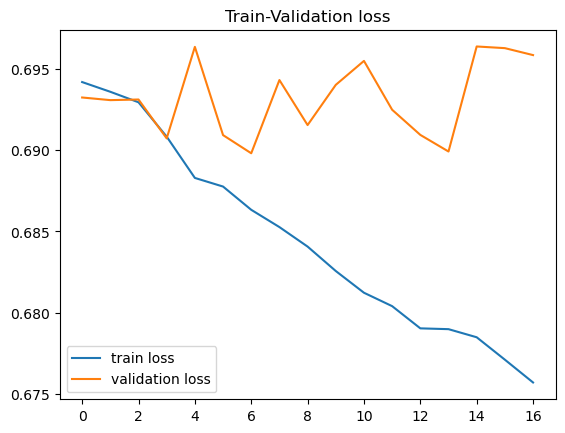

In [39]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [40]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.7025, 'male': 0.625, 'average': 0.6637500000000001}
precision {'female': 0.6611764705882353, 'male': 0.6685236768802229, 'average': 0.6648500737342291}
f1 {'female': 0.6812121212121212, 'male': 0.6460296096904441, 'average': 0.6636208654512826}
accuracy 0.6645408163265306


Evaluación en el conjunto el conjunto to
recall {'female': 0.7007874015748031, 'male': 0.6520681265206812, 'average': 0.6764277640477422}
precision {'female': 0.651219512195122, 'male': 0.7015706806282722, 'average': 0.6763950964116971}
f1 {'female': 0.6750948166877371, 'male': 0.6759142496847413, 'average': 0.6755045331862393}
accuracy 0.6755050505050505


Evaluación en el conjunto el conjunto as
recall {'female': 0.8113207547169812, 'male': 0.6616161616161617, 'average': 0.7364684581665715}
precision {'female': 0.6919540229885057, 'male': 0.7891566265060241, 'average': 0.7405553247472649}
f1 {'female': 0.7468982630272953, 'male': 0.7197802197802197,

In [41]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6950963054384504 	 Validation loss: 0.692381846702705 	 
  1%|          | 574/57400 [01:46<2:29:26,  6.34it/s]
Epoch 2 	 Training loss: 0.6943903537369771 	 Validation loss: 0.6927961616192834 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:33<2:22:19,  6.59it/s]
Epoch 3 	 Training loss: 0.6927845541400777 	 Validation loss: 0.6909030665785579 	 
  3%|▎         | 1722/57400 [05:21<2:27:47,  6.28it/s]
Epoch 4 	 Training loss: 0.6905531016168694 	 Validation loss: 0.6918843439069845 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:07<2:27:39,  6.22it/s]
Epoch 5 	 Training loss: 0.6882510343079783 	 Validation loss: 0.6889351909443483 	 
  5%|▌         | 2870/57400 [08:55<2:43:02,  5.57it/s]
Epoch 6 	 Training loss: 0.6872335524924541 	 Validation loss: 0.691070677870411 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:41<2:19:31,  6.45it/s]
Epoch 7 	 Training loss: 0.684985161969886 	 Validation loss: 0.691137084516

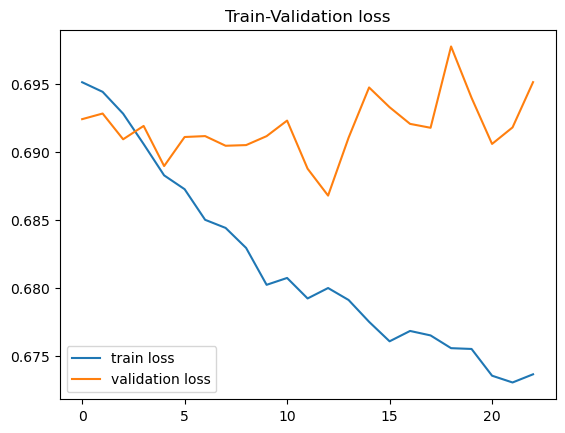

In [42]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [43]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6325, 'male': 0.640625, 'average': 0.6365624999999999}
precision {'female': 0.6470588235294118, 'male': 0.6259541984732825, 'average': 0.6365065110013471}
f1 {'female': 0.6396965865992414, 'male': 0.6332046332046333, 'average': 0.6364506099019374}
accuracy 0.6364795918367347


Evaluación en el conjunto el conjunto to
recall {'female': 0.6272965879265092, 'male': 0.8175182481751825, 'average': 0.7224074180508459}
precision {'female': 0.7611464968152867, 'male': 0.702928870292887, 'average': 0.7320376835540868}
f1 {'female': 0.6877697841726619, 'male': 0.7559055118110235, 'average': 0.7218376479918427}
accuracy 0.726010101010101


Evaluación en el conjunto el conjunto as
recall {'female': 0.8355795148247979, 'male': 0.8106060606060606, 'average': 0.8230927877154293}
precision {'female': 0.8051948051948052, 'male': 0.8403141361256544, 'average': 0.8227544706602299}
f1 {'female': 0.8201058201058201, 'male': 0.825192802056555

In [44]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6937943138311964 	 Validation loss: 0.6928437079413462 	 
  1%|          | 574/57400 [01:46<2:28:44,  6.37it/s]
Epoch 2 	 Training loss: 0.6934192525385149 	 Validation loss: 0.6926594800868277 	 
  2%|▏         | 1148/57400 [03:39<3:31:41,  4.43it/s]
Epoch 3 	 Training loss: 0.6909645632792017 	 Validation loss: 0.6919578273417586 	 
  3%|▎         | 1722/57400 [05:55<2:53:14,  5.36it/s]
Epoch 4 	 Training loss: 0.6881298844407244 	 Validation loss: 0.6906787116648787 	 
  4%|▍         | 2296/57400 [08:06<2:54:41,  5.26it/s]
Epoch 5 	 Training loss: 0.6863598611712041 	 Validation loss: 0.6919350745314259 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:12<2:52:05,  5.28it/s]
Epoch 6 	 Training loss: 0.684813432369498 	 Validation loss: 0.6919620360358286 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:11<2:27:08,  6.11it/s]
Epoch 7 	 Training loss: 0.68330161216367 	 Validation loss: 0.6879880670773781 	 
  7%|▋         | 4018

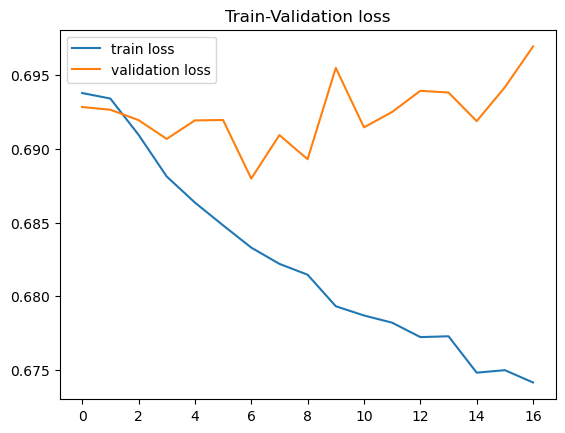

In [45]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [46]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.6375, 'male': 0.5963541666666666, 'average': 0.6169270833333333}
precision {'female': 0.6219512195121951, 'male': 0.6122994652406417, 'average': 0.6171253423764185}
f1 {'female': 0.6296296296296297, 'male': 0.604221635883905, 'average': 0.6169256327567674}
accuracy 0.6173469387755102


Evaluación en el conjunto el conjunto to
recall {'female': 0.6666666666666666, 'male': 0.7226277372262774, 'average': 0.694647201946472}
precision {'female': 0.6902173913043478, 'male': 0.7004716981132075, 'average': 0.6953445447087776}
f1 {'female': 0.6782376502002669, 'male': 0.711377245508982, 'average': 0.6948074478546244}
accuracy 0.6957070707070707


Evaluación en el conjunto el conjunto as
recall {'female': 0.816711590296496, 'male': 0.7171717171717171, 'average': 0.7669416537341065}
precision {'female': 0.7301204819277108, 'male': 0.8068181818181818, 'average': 0.7684693318729463}
f1 {'female': 0.7709923664122138, 'male': 0.7593582

Resultados finales

In [47]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task]['f1']['average']))
        print(f'{metric} etiqueta male:',mean(global_metrics[task]['f1']['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task]['f1']['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.6389990360366624
f1 etiqueta male: 0.6278186262596608
f1 etiqueta female:  0.650179445813664


TO
Resultado global f1: 0.6973832096775688
f1 etiqueta male: 0.7143990023349156
f1 etiqueta female:  0.680367417020222


AS
Resultado global f1: 0.7737212933586929
f1 etiqueta male: 0.7681104368689428
f1 etiqueta female:  0.7793321498484431


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6389990360366624
recall etiqueta male: 0.6278186262596608
recall etiqueta female:  0.650179445813664


TO
Resultado global recall: 0.6973832096775688
recall etiqueta male: 0.7143990023349156
recall etiqueta female:  0.680367417020222


AS
Resultado global recall: 0.7737212933586929
recall etiqueta male: 0.7681104368689428
recall etiqueta female:  0.7793321498484431


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.6389990360366624
precision etiqueta male: 0.6278186262596608
precision etiqueta female:  0.65017